# Genetic Algorithm Assignment
30% of the overall grade for this module

Marks indciated in sections below are based on percentage of marks allocated for this module

In this assignment you must choose a problem, and attempt to use the Genetic Alogrithm that we developed in class to solve this problem.





## The Problem         **(~30%)**

*   Description of the problem





---

(Double click then ...)  Type Here...

---



*   Discussion of the suitablity of Genetic Algorithms


---

(Double click then ...)  Type Here...

---



*   Complexity of the problem  (Overall marks allocated based on ..)

# The problem and the cost function   **(~20%)**

In [2]:
#imports
import numpy as np
from PIL import Image, ImageDraw
from copy import deepcopy

def create_shape_image(width, height, shape):
    image = Image.new("RGB", (width, height), "black")
    draw = ImageDraw.Draw(image)

    if shape == "circle":
        draw.ellipse([(25, 25), (75, 75)], fill="white", outline ="white")
    elif shape == "square":
        draw.rectangle([(25, 25), (75, 75)], fill="white", outline="white")
    elif shape == "triangle":
        draw.polygon([(50, 25), (25, 75), (75, 75)], fill="white", outline="white")

    return np.array(image)


In [5]:
target_image = Image.fromarray(create_shape_image(50, 50, "circle"))

#test = create_shape_image(50, 50, "circle")
test = create_random_image(2, 2)
target_image = Image.fromarray(test)
target_image.show()

In [ ]:
file_path = './testimgcopy.png'

# Open the image file
with Image.open(file_path) as img:
    # Convert the image to a numpy array
    img_array = np.array(img)
    
test_image = Image.fromarray(img_array[:, :, :3])
test_image.show()
target_image = test_image

In [145]:
def cost_function(individual, target_image):
    #print the target_image as a numpy array
    #print(np.array(target_image))
    
    #print(individual)
    return np.mean((individual.astype(np.uint64) - np.array(target_image).astype(np.uint64)) ** 2)
    
def create_random_image(width, height):
    return np.random.randint(0, 255, (width, height, 3), dtype=np.uint8)

class problem:
    def __init__(self):
        self.width = 2
        self.height = 2
        self.number_of_genes = self.width * self.height
        self.cost_function = cost_function


In [39]:
ptest = problem()
ptest.width

10

# The Individual **(~30%)**


*   Chromosone
*   Crossover
*   Mutation



## Discussion and justification on the approaches taken for the above

---

(Double click then ...)  Type Here...

---



In [146]:
# Code for individual class in here

def clamp(value, min_value, max_value):
    """Ensure 'value' falls within the range [min_value, max_value]."""
    return max(min_value, min(value, max_value))
class individual:
    chromosome = None
    cost = 9999999
    number_of_genes = None

    def __init__(self, prob):
        self.chromosome = create_random_image(prob.width, prob.height)
        self.number_of_genes = prob.number_of_genes
        self.cost = prob.cost_function(self.chromosome, target_image)
        
    def mutate(self, mutation_rate, mutation_range):
        for i in range(self.number_of_genes):
            if np.random.uniform() < mutation_rate:
                row_to_mutate = np.random.randint(0, len(self.chromosome))
                pixel_to_mutate = np.random.randint(0, len(self.chromosome[row_to_mutate]))
                pixel = self.chromosome[row_to_mutate][pixel_to_mutate]

                # Generate mutation for each color channel and clamp the values
                r_mutation = clamp(np.random.uniform(pixel[0] - mutation_range, pixel[0] + mutation_range), 0, 255)
                g_mutation = clamp(np.random.uniform(pixel[1] - mutation_range, pixel[1] + mutation_range), 0, 255)
                b_mutation = clamp(np.random.uniform(pixel[2] - mutation_range, pixel[2] + mutation_range), 0, 255)

                # Update the pixel values
                self.chromosome[row_to_mutate][pixel_to_mutate] = [r_mutation, g_mutation, b_mutation]
            
 
    def crossover(self,parent2):
       
        mid_point = len(self.chromosome) // 2
        # Create child images by swapping halves
        child1 = deepcopy(self)
        child1.chromosome[mid_point:] = parent2.chromosome[mid_point:]

        child2 = deepcopy(parent2)
        child2.chromosome[mid_point:] = self.chromosome[mid_point:]

        return child1, child2
        
        
    
                
            
              

[200  29 206]
[163  70 255]


(2, 2, 3)

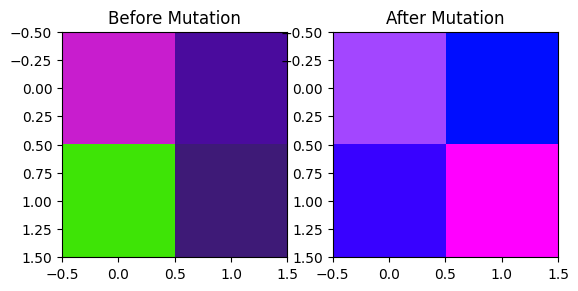

In [147]:
import matplotlib.pyplot as plt
p1 = problem()
ind1 = individual(p1)
img = Image.fromarray(ind1.chromosome, 'RGB')
#show two image plots side by side
fig = plt.figure()
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(img)
a.set_title('Before Mutation')

print(ind1.chromosome[0][0])

for i in range(0, 100):
    ind1.mutate(1, 255)
    
print(ind1.chromosome[0][0])

img1 = Image.fromarray(ind1.chromosome, 'RGB')

b = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(img1)
b.set_title('After Mutation')

ind1.chromosome.shape

In [11]:
ind2 = individual(p1)
ind3, ind4 = ind1.crossover(ind2)



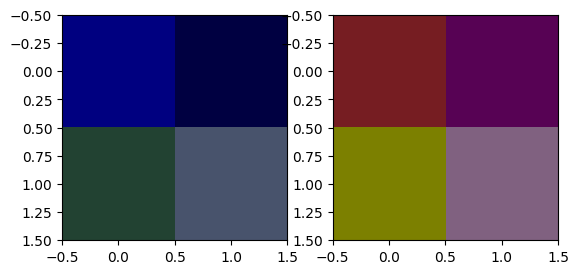

In [12]:
img = Image.fromarray(ind3.chromosome, 'RGB')

fig = plt.figure()
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(img)

img1 = Image.fromarray(ind4.chromosome, 'RGB')

b = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(img1)


## Running the algorithm  **(~10%)**

*   Parameter choices
*   Modifications (if any) to run_genetic
*   Rationale for the above



---

(Double click then ...)  Type Here...

---



In [148]:
#  Parameter class here
class parameters:
  def __init__(self):
    self.population  = 2000
    self.number_of_generations = 400
    self.child_rate_per_generation = 1
    self.crossover_explore_rate = 0.5
    self.gene_mutate_rate = 1
    self.gene_mutate_range = 255

In [149]:
def choose_indices_from(number_in_list):
  index_1 = np.random.randint(number_in_list)
  index_2 = np.random.randint(number_in_list)
  if index_1 == index_2:
    return choose_indices_from(number_in_list)
  return index_1,index_2

def run_genetic(prob, params):
    cost_function = prob.cost_function
        
    number_in_population = params.population
    max_number_of_generations = params.number_of_generations
    number_of_children_per_generation = params.child_rate_per_generation * number_in_population
    explore_crossover = params.crossover_explore_rate
    gene_mutate_rate = params.gene_mutate_rate
    gene_mutate_range = params.gene_mutate_range
    
    population = []
    
    best_solution = individual(prob)
    best_solution.cost = np.float64('inf')
    for i in range(number_in_population):
        new_individual = individual(prob)
        population.append(new_individual)

        if new_individual.cost < best_solution.cost:
            best_solution = deepcopy(new_individual)

    gene_mutate_modifier = 1
    modified_gene_mutate_rate = 1
    
    for _iteration in range(max_number_of_generations):
        print(_iteration)
        
        if _iteration > max_number_of_generations * 0.7:
            modified_gene_mutate_rate = 0.3
            gene_mutate_range = 255 * 0.2
            print("Mutation rate set to 0.3")
        elif _iteration > max_number_of_generations * 0.5:
            modified_gene_mutate_rate = 0.5
            gene_mutate_range = 255 * 0.5
            print("Mutation rate set to 0.3")
    
            
        children = []
        debug_index = 0
        while len(children) < number_of_children_per_generation:
            
            #if debug_index % 250 == 0:
            #    print(str(debug_index))
                
            
                
            debug_index += 1
            parent1_index , parent2_index = choose_indices_from(len(population))
            parent1 = population[parent1_index]
            parent2 = population[parent2_index]

            child1, child2 = parent1.crossover(parent2)
            child1.mutate(modified_gene_mutate_rate, gene_mutate_range)
            child1.cost = cost_function(child1.chromosome, target_image)
            child2.mutate(modified_gene_mutate_rate, gene_mutate_range)
            child2.cost = cost_function(child2.chromosome, target_image)

            # add children in list
            children.append(child1)
            children.append(child2)


        population += children

        population = sorted(population, key = lambda x:x.cost)

        population = population[:number_in_population]

        if population[0].cost < best_solution.cost:
            best_solution = deepcopy(population[0])

        #plt.imshow(population[0].chromosome)
        #plt.title(f"Generation {_iteration}, Cost: {population[0].cost}")
        #plt.show()
        
        print("Best Solution for iteration " + str(_iteration) + " has cost of " + str (best_solution.cost) + " " + str(gene_mutate_range))
        

    return best_solution

In [150]:
params = parameters()

In [151]:
#  Running of the algorithm with outputs here
p1 = problem()
b1 = run_genetic(p1, params)

0
Best Solution for iteration 0 has cost of 1882.5833333333333 255
1
Best Solution for iteration 1 has cost of 1882.5833333333333 255
2
Best Solution for iteration 2 has cost of 1207.4166666666667 255
3
Best Solution for iteration 3 has cost of 1207.4166666666667 255
4
Best Solution for iteration 4 has cost of 1207.4166666666667 255
5
Best Solution for iteration 5 has cost of 1207.4166666666667 255
6
Best Solution for iteration 6 has cost of 1207.4166666666667 255
7
Best Solution for iteration 7 has cost of 1207.4166666666667 255
8
Best Solution for iteration 8 has cost of 1205.25 255
9
Best Solution for iteration 9 has cost of 1205.25 255
10
Best Solution for iteration 10 has cost of 1205.25 255
11
Best Solution for iteration 11 has cost of 1205.25 255
12
Best Solution for iteration 12 has cost of 1205.25 255
13
Best Solution for iteration 13 has cost of 1205.25 255
14
Best Solution for iteration 14 has cost of 1205.25 255
15
Best Solution for iteration 15 has cost of 1205.25 255
16
B

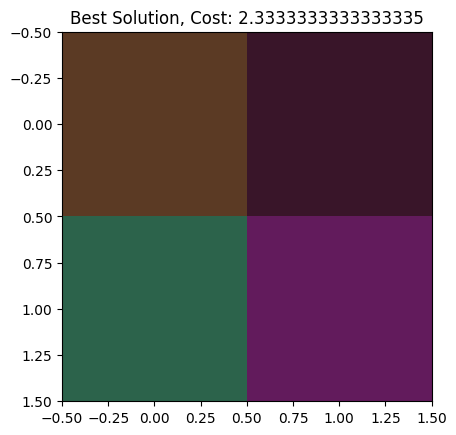

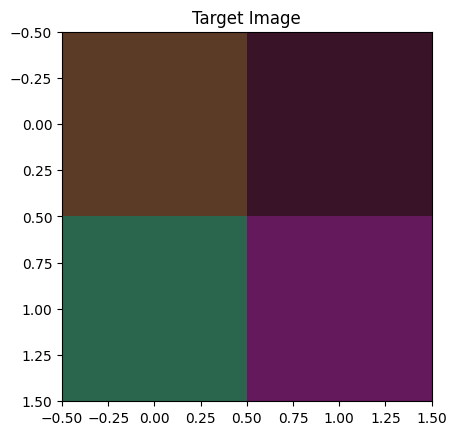

In [144]:
plt.imshow(b1.chromosome)
plt.title(f"Best Solution, Cost: {b1.cost}")
plt.show()


plt.imshow(target_image)
plt.title("Target Image")
plt.show()

In [135]:
print(type(b1.chromosome))
print(b1.chromosome)
#print(test)

print(type(test))
print(test.shape)

chromosome1_corrected = np.array([[[107, 90, 38], [9, 68, 24]], [[74, 117, 110], [99, 89, 12]]])
chromosome2_corrected = np.array([[[91, 58, 38], [57, 20, 40]], [[42, 101, 78], [99, 25, 92]]])

chromosome3 = np.array(b1.chromosome)

#check if b1.chromosome is equal to chromosome1_corrected  
print(np.array_equal(chromosome1_corrected, b1.chromosome))
print(np.array_equal(chromosome2_corrected, test))


<class 'numpy.ndarray'>
[[[ 59 106  38]
  [121   4  24]]

 [[106 101  94]
  [ 35 121  76]]]
<class 'numpy.ndarray'>
(2, 2, 3)
False
True


In [142]:
print(str(cost_function(chromosome1_corrected, chromosome2_corrected)))
print(str(cost_function(b1.chromosome, test)))
print(str(cost_function(b1.chromosome, test)))

1578.6666666666667
2154.6666666666665
2154.6666666666665


In [ ]:
#  If changes to params or reruns of iterations dont overwrite, create more cells and copy code down to show evolution of final solution

## Results and conclusions    **(~10%)**

---

(Double click then ...)  Type Here...

---

